In [76]:
import pymc as pm
import pandas as pd
import numpy as np
import aesara
import aesara.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import math
import seaborn as sns

RANDOM_SEED = 227
rng = np.random.default_rng(RANDOM_SEED)
aesara.config.compute_test_value='off'
aesara.config.floatX = 'float32'
%config InlineBackend.figure_format = 'retina'

#https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

In [77]:
data = pd.read_excel('toy.xlsx')
data = data.drop(columns=['P(A)','P(B)','P(C|A)','P(C|B)','P(D|C)'])

A, B, C, D = data['A'], data['B'], data['C'], data['D']

length = 12 # hours

num_step = math.floor(len(A)/length)

A_dist, B_dist, C_dist, D_dist = [np.zeros((1,num_step)).ravel() for i in [1,1,1,1]]

for i in np.arange(num_step):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_dist[i] = np.sum(A[(i-1)*length:i*length])
    B_dist[i] = np.sum(B[(i-1)*length:i*length])
    C_dist[i] = np.sum(C[(i-1)*length:i*length])
    D_dist[i] = np.sum(D[(i-1)*length:i*length])

In [78]:
B_A_data = data[data['A']==0]['B']
C_A_data = data[data['A']==0]['C']
D_A_data = data[data['A']==0]['D']
print(len(B_A_data))

A_B_data = data[data['B']==0]['A']
C_B_data = data[data['B']==0]['C']
D_B_data = data[data['B']==0]['D']
print(len(A_B_data))

A_C_data = data[data['C']==0]['A']
B_C_data = data[data['C']==0]['B']
D_C_data = data[data['C']==0]['D']
print(len(A_C_data))

A_D_data = data[data['D']==0]['A']
B_D_data = data[data['D']==0]['B']
C_D_data = data[data['D']==0]['C']
print(len(C_D_data))

487
295
705
833


In [79]:
num_step_given_A = math.floor(len(B_A_data)/length)
num_step_given_B = math.floor(len(A_B_data)/length)
num_step_given_C = math.floor(len(A_C_data)/length)
num_step_given_D = math.floor(len(A_D_data)/length)

B_A_dist, C_A_dist, D_A_dist = [np.zeros((1,num_step_given_A)).ravel() for i in [1,1,1]]
A_B_dist, C_B_dist, D_B_dist = [np.zeros((1,num_step_given_B)).ravel() for i in [1,1,1]]
A_C_dist, B_C_dist, D_C_dist = [np.zeros((1,num_step_given_C)).ravel() for i in [1,1,1]]
A_D_dist, B_D_dist, C_D_dist = [np.zeros((1,num_step_given_D)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_A):
    B_A_dist[i] = np.sum(B_A_data[(i-1)*length:i*length])
    C_A_dist[i] = np.sum(C_A_data[(i-1)*length:i*length])
    D_A_dist[i] = np.sum(D_A_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_B):
    A_B_dist[i] = np.sum(A_B_data[(i-1)*length:i*length])
    C_B_dist[i] = np.sum(C_B_data[(i-1)*length:i*length])
    D_B_dist[i] = np.sum(D_B_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_C):
    A_C_dist[i] = np.sum(A_C_data[(i-1)*length:i*length])
    B_C_dist[i] = np.sum(B_C_data[(i-1)*length:i*length])
    D_C_dist[i] = np.sum(D_C_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_D):
    A_D_dist[i] = np.sum(A_D_data[(i-1)*length:i*length])
    B_D_dist[i] = np.sum(B_D_data[(i-1)*length:i*length])
    C_D_dist[i] = np.sum(C_D_data[(i-1)*length:i*length])

In [80]:
A_and_B_dist, A_and_C_dist, A_and_D_dist, B_and_C_dist, B_and_D_dist, C_and_D_dist = [np.zeros((1,num_step)).ravel() for i in [1,1,1,1,1,1]]

for i in np.arange(num_step):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_dist[i] = np.sum(A*B[(i-1)*length:i*length])
    A_and_C_dist[i] = np.sum(A*C[(i-1)*length:i*length])
    A_and_D_dist[i] = np.sum(A*D[(i-1)*length:i*length])
    B_and_C_dist[i] = np.sum(B*C[(i-1)*length:i*length])
    B_and_D_dist[i] = np.sum(B*D[(i-1)*length:i*length])
    C_and_D_dist[i] = np.sum(C*D[(i-1)*length:i*length])

In [81]:
with pm.Model() as model1:
    prior_alpha = 2
    prior_beta = 1

    alpha0_A = pm.Gamma('alpha0_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_B = pm.Gamma('alpha0_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_C = pm.Gamma('alpha0_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_D = pm.Gamma('alpha0_D', alpha = prior_alpha, beta=prior_beta)

    beta0_A = pm.Gamma('beta0_A', alpha = prior_alpha, beta =prior_beta)
    beta0_B = pm.Gamma('beta0_B', alpha = prior_alpha, beta =prior_beta)
    beta0_C = pm.Gamma('beta0_C', alpha = prior_alpha, beta =prior_beta)
    beta0_D = pm.Gamma('beta0_D', alpha = prior_alpha, beta =prior_beta)

    p_A = pm.Beta('p_A', alpha = alpha0_A, beta = beta0_A)
    p_B = pm.Beta('p_B', alpha = alpha0_B, beta = beta0_B)
    p_C = pm.Beta('p_C', alpha = alpha0_C, beta = beta0_C)
    p_D = pm.Beta('p_D', alpha = alpha0_D, beta = beta0_D)
    
    # They are for to get P(A), P(B), P(C), and P(D)
    bino_A = pm.Binomial('bino_A', n = length, p = p_A, observed = A_dist)
    bino_B = pm.Binomial('bino_B', n = length, p = p_B, observed = B_dist)
    bino_C = pm.Binomial('bino_C', n = length, p = p_C, observed = C_dist)
    bino_D = pm.Binomial('bino_D', n = length, p = p_D, observed = D_dist)
    
with model1:
    samples = pm.sample(draws = 4000)

#pm.plot_trace(samples, filter_vars="like", combined=True, kind="trace", figsize = (12,40));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A, alpha0_B, alpha0_C, alpha0_D, beta0_A, beta0_B, beta0_C, beta0_D, p_A, p_B, p_C, p_D]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 7 seconds.


In [82]:
with pm.Model() as model2:
    prior_alpha = 2
    prior_beta = 1

    # Let's start conditional dist. 
    alpha0_A_B = pm.Gamma('alpha0_A_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_C = pm.Gamma('alpha0_A_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_D = pm.Gamma('alpha0_A_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_A = pm.Gamma('alpha0_B_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_C = pm.Gamma('alpha0_B_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_D = pm.Gamma('alpha0_B_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_A = pm.Gamma('alpha0_C_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_B = pm.Gamma('alpha0_C_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_D = pm.Gamma('alpha0_C_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_A = pm.Gamma('alpha0_D_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_B = pm.Gamma('alpha0_D_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_C = pm.Gamma('alpha0_D_C', alpha = prior_alpha, beta=prior_beta)

    beta0_A_B = pm.Gamma('beta0_A_B', alpha = prior_alpha, beta=prior_beta)
    beta0_A_C = pm.Gamma('beta0_A_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_D = pm.Gamma('beta0_A_D', alpha = prior_alpha, beta=prior_beta)
    beta0_B_A = pm.Gamma('beta0_B_A', alpha = prior_alpha, beta=prior_beta)
    beta0_B_C = pm.Gamma('beta0_B_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_D = pm.Gamma('beta0_B_D', alpha = prior_alpha, beta=prior_beta)
    beta0_C_A = pm.Gamma('beta0_C_A', alpha = prior_alpha, beta=prior_beta)
    beta0_C_B = pm.Gamma('beta0_C_B', alpha = prior_alpha, beta=prior_beta)
    beta0_C_D = pm.Gamma('beta0_C_D', alpha = prior_alpha, beta=prior_beta)
    beta0_D_A = pm.Gamma('beta0_D_A', alpha = prior_alpha, beta=prior_beta)
    beta0_D_B = pm.Gamma('beta0_D_B', alpha = prior_alpha, beta=prior_beta)
    beta0_D_C = pm.Gamma('beta0_D_C', alpha = prior_alpha, beta=prior_beta)

    p_A_B = pm.Beta('p_A_B', alpha = alpha0_A_B, beta= beta0_A_B)
    p_A_C = pm.Beta('p_A_C', alpha = alpha0_A_C, beta= beta0_A_C)
    p_A_D = pm.Beta('p_A_D', alpha = alpha0_A_D, beta= beta0_A_D)
    p_B_A = pm.Beta('p_B_A', alpha = alpha0_B_A, beta= beta0_B_A)
    p_B_C = pm.Beta('p_B_C', alpha = alpha0_B_C, beta= beta0_B_C)
    p_B_D = pm.Beta('p_B_D', alpha = alpha0_B_D, beta= beta0_B_D)
    p_C_A = pm.Beta('p_C_A', alpha = alpha0_C_A, beta= beta0_C_A)
    p_C_B = pm.Beta('p_C_B', alpha = alpha0_C_B, beta= beta0_C_B)
    p_C_D = pm.Beta('p_C_D', alpha = alpha0_C_D, beta= beta0_C_D)
    p_D_A = pm.Beta('p_D_A', alpha = alpha0_D_A, beta= beta0_D_A)
    p_D_B = pm.Beta('p_D_B', alpha = alpha0_D_B, beta= beta0_D_B)
    p_D_C = pm.Beta('p_D_C', alpha = alpha0_D_C, beta= beta0_D_C)

    # They are for to get conditional probabilities
    bino_A_B = pm.Binomial('bino_A_B', n = length, p= p_A_B, observed = A_B_dist)
    bino_A_C = pm.Binomial('bino_A_C', n = length, p= p_A_C, observed = A_C_dist)
    bino_A_D = pm.Binomial('bino_A_D', n = length, p= p_A_D, observed = A_D_dist)
    bino_B_A = pm.Binomial('bino_B_A', n = length, p= p_B_A, observed = B_A_dist)
    bino_B_C = pm.Binomial('bino_B_C', n = length, p= p_B_C, observed = B_C_dist)
    bino_B_D = pm.Binomial('bino_B_D', n = length, p= p_B_D, observed = B_D_dist)
    bino_C_A = pm.Binomial('bino_C_A', n = length, p= p_C_A, observed = C_A_dist)
    bino_C_B = pm.Binomial('bino_C_B', n = length, p= p_C_B, observed = C_B_dist)
    bino_C_D = pm.Binomial('bino_C_D', n = length, p= p_C_D, observed = C_D_dist)
    bino_D_A = pm.Binomial('bino_D_A', n = length, p= p_D_A, observed = D_A_dist)
    bino_D_B = pm.Binomial('bino_D_B', n = length, p= p_D_B, observed = D_B_dist)
    bino_D_C = pm.Binomial('bino_D_C', n = length, p= p_D_C, observed = D_C_dist)

with model2:
    samples2 = pm.sample(draws = 4000)

# pm.plot_trace(samples2, 
#             var_names = ['p_A_B', 'p_A_C', 'p_A_D', 'p_B_A', 'p_B_C', 'p_B_D', 
#             'p_C_A', 'p_C_B', 'p_C_D', 'p_D_A', 'p_D_B', 'p_D_C'],
#             filter_vars="like", combined=True, kind="trace", figsize = (12,40));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_B, alpha0_A_C, alpha0_A_D, alpha0_B_A, alpha0_B_C, alpha0_B_D, alpha0_C_A, alpha0_C_B, alpha0_C_D, alpha0_D_A, alpha0_D_B, alpha0_D_C, beta0_A_B, beta0_A_C, beta0_A_D, beta0_B_A, beta0_B_C, beta0_B_D, beta0_C_A, beta0_C_B, beta0_C_D, beta0_D_A, beta0_D_B, beta0_D_C, p_A_B, p_A_C, p_A_D, p_B_A, p_B_C, p_B_D, p_C_A, p_C_B, p_C_D, p_D_A, p_D_B, p_D_C]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 113 seconds.


In [83]:
with pm.Model() as model3:
    prior_alpha = 2
    prior_beta = 1

    # Let's start conditional dist. 
    alpha0_A_and_B = pm.Gamma('alpha0_A_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_C = pm.Gamma('alpha0_A_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D = pm.Gamma('alpha0_A_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_C = pm.Gamma('alpha0_B_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D = pm.Gamma('alpha0_B_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_and_D = pm.Gamma('alpha0_C_D', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B = pm.Gamma('beta0_A_B', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_C = pm.Gamma('beta0_A_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D = pm.Gamma('beta0_A_D', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_C = pm.Gamma('beta0_B_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D = pm.Gamma('beta0_B_D', alpha = prior_alpha, beta=prior_beta)
    beta0_C_and_D = pm.Gamma('beta0_C_D', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B = pm.Beta('p_A_and_B', alpha = alpha0_A_and_B, beta= beta0_A_and_B)
    p_A_and_C = pm.Beta('p_A_and_C', alpha = alpha0_A_and_C, beta= beta0_A_and_C)
    p_A_and_D = pm.Beta('p_A_and_D', alpha = alpha0_A_and_D, beta= beta0_A_and_D)
    p_B_and_C = pm.Beta('p_B_and_C', alpha = alpha0_B_and_C, beta= beta0_B_and_C)
    p_B_and_D = pm.Beta('p_B_and_D', alpha = alpha0_B_and_D, beta= beta0_B_and_D)
    p_C_and_D = pm.Beta('p_C_and_D', alpha = alpha0_C_and_D, beta= beta0_C_and_D)
    
    # They are for to get conditional probabilities
    bino_A_and_B = pm.Binomial('bino_A_and_B', n = length, p= p_A_and_B, observed = A_and_B_dist)
    bino_A_and_C = pm.Binomial('bino_A_and_C', n = length, p= p_A_and_C, observed = A_and_C_dist)
    bino_A_and_D = pm.Binomial('bino_A_and_D', n = length, p= p_A_and_D, observed = A_and_D_dist)
    bino_B_and_C = pm.Binomial('bino_B_and_C', n = length, p= p_B_and_C, observed = B_and_C_dist)
    bino_B_and_D = pm.Binomial('bino_B_and_D', n = length, p= p_B_and_D, observed = B_and_D_dist)
    bino_C_and_D = pm.Binomial('bino_C_and_D', n = length, p= p_C_and_D, observed = C_and_D_dist)

with model3:
    samples3 = pm.sample(draws=4000)

# pm.plot_trace(samples3, 
#             var_names = ['p_A_and_B', 'p_A_and_C', 'p_A_and_D', 'p_B_and_C', 'p_B_and_D', 'p_C_and_D'],
#             filter_vars="like", combined=True, kind="trace", figsize = (12,25));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_B, alpha0_A_C, alpha0_A_D, alpha0_B_C, alpha0_B_D, alpha0_C_D, beta0_A_B, beta0_A_C, beta0_A_D, beta0_B_C, beta0_B_D, beta0_C_D, p_A_and_B, p_A_and_C, p_A_and_D, p_B_and_C, p_B_and_D, p_C_and_D]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 10 seconds.


In [84]:
samples_p_A = samples.posterior.p_A.values[:,500:].ravel()
samples_p_B = samples.posterior.p_B.values[:,500:].ravel()
samples_p_C = samples.posterior.p_C.values[:,500:].ravel()
samples_p_D = samples.posterior.p_D.values[:,500:].ravel()

samples_p_A_B = samples2.posterior.p_A_B.values[:,500:].ravel()
samples_p_A_C = samples2.posterior.p_A_C.values[:,500:].ravel()
samples_p_A_D = samples2.posterior.p_A_D.values[:,500:].ravel()
samples_p_B_A = samples2.posterior.p_B_A.values[:,500:].ravel()
samples_p_B_C = samples2.posterior.p_B_C.values[:,500:].ravel()
samples_p_B_D = samples2.posterior.p_B_D.values[:,500:].ravel()
samples_p_C_A = samples2.posterior.p_C_A.values[:,500:].ravel()
samples_p_C_B = samples2.posterior.p_C_B.values[:,500:].ravel()
samples_p_C_D = samples2.posterior.p_C_D.values[:,500:].ravel()
samples_p_D_A = samples2.posterior.p_D_A.values[:,500:].ravel()
samples_p_D_B = samples2.posterior.p_D_B.values[:,500:].ravel()
samples_p_D_C = samples2.posterior.p_D_C.values[:,500:].ravel()

samples_p_A_and_B = samples3.posterior.p_A_and_B.values[:,500:].ravel()
samples_p_A_and_C = samples3.posterior.p_A_and_C.values[:,500:].ravel()
samples_p_A_and_D = samples3.posterior.p_A_and_D.values[:,500:].ravel()
samples_p_B_and_C = samples3.posterior.p_B_and_C.values[:,500:].ravel()
samples_p_B_and_D = samples3.posterior.p_B_and_D.values[:,500:].ravel()
samples_p_C_and_D = samples3.posterior.p_C_and_D.values[:,500:].ravel()

$$
Correlation(A,B) = \frac{p(A,B)-P(A)P(B)}{\sqrt{P(A)(1-P(A))P(B)(1-P(B))}}
$$ 

Reference: [https://www.statisticshowto.com/phi-coefficient-mean-square-contingency-coefficient/ & https://math.stackexchange.com/questions/1751950/from-correlation-coefficient-to-conditional-probability]


In [85]:
def phi_corr(p_a,p_b,p_a_and_b):
    numerator = p_a_and_b-p_a*p_b
    denominator = np.sqrt(p_a*(1-p_a)*p_b*(1-p_b))
    return numerator/denominator

In [86]:
def phi_corr2(p_a,p_b,p_a_b):
    numerator = (p_a_b-p_a)*p_b
    denominator = np.sqrt(p_a*(1-p_a)*p_b*(1-p_b))
    return numerator/denominator

In [87]:
cor_AB = phi_corr(samples_p_A, samples_p_B, samples_p_A_and_B)
cor_AC = phi_corr(samples_p_A, samples_p_C, samples_p_A_and_C)
cor_AD = phi_corr(samples_p_A, samples_p_D, samples_p_A_and_D)
cor_BC = phi_corr(samples_p_B, samples_p_C, samples_p_B_and_C)
cor_BD = phi_corr(samples_p_B, samples_p_D, samples_p_B_and_D)
cor_CD = phi_corr(samples_p_C, samples_p_D, samples_p_C_and_D)

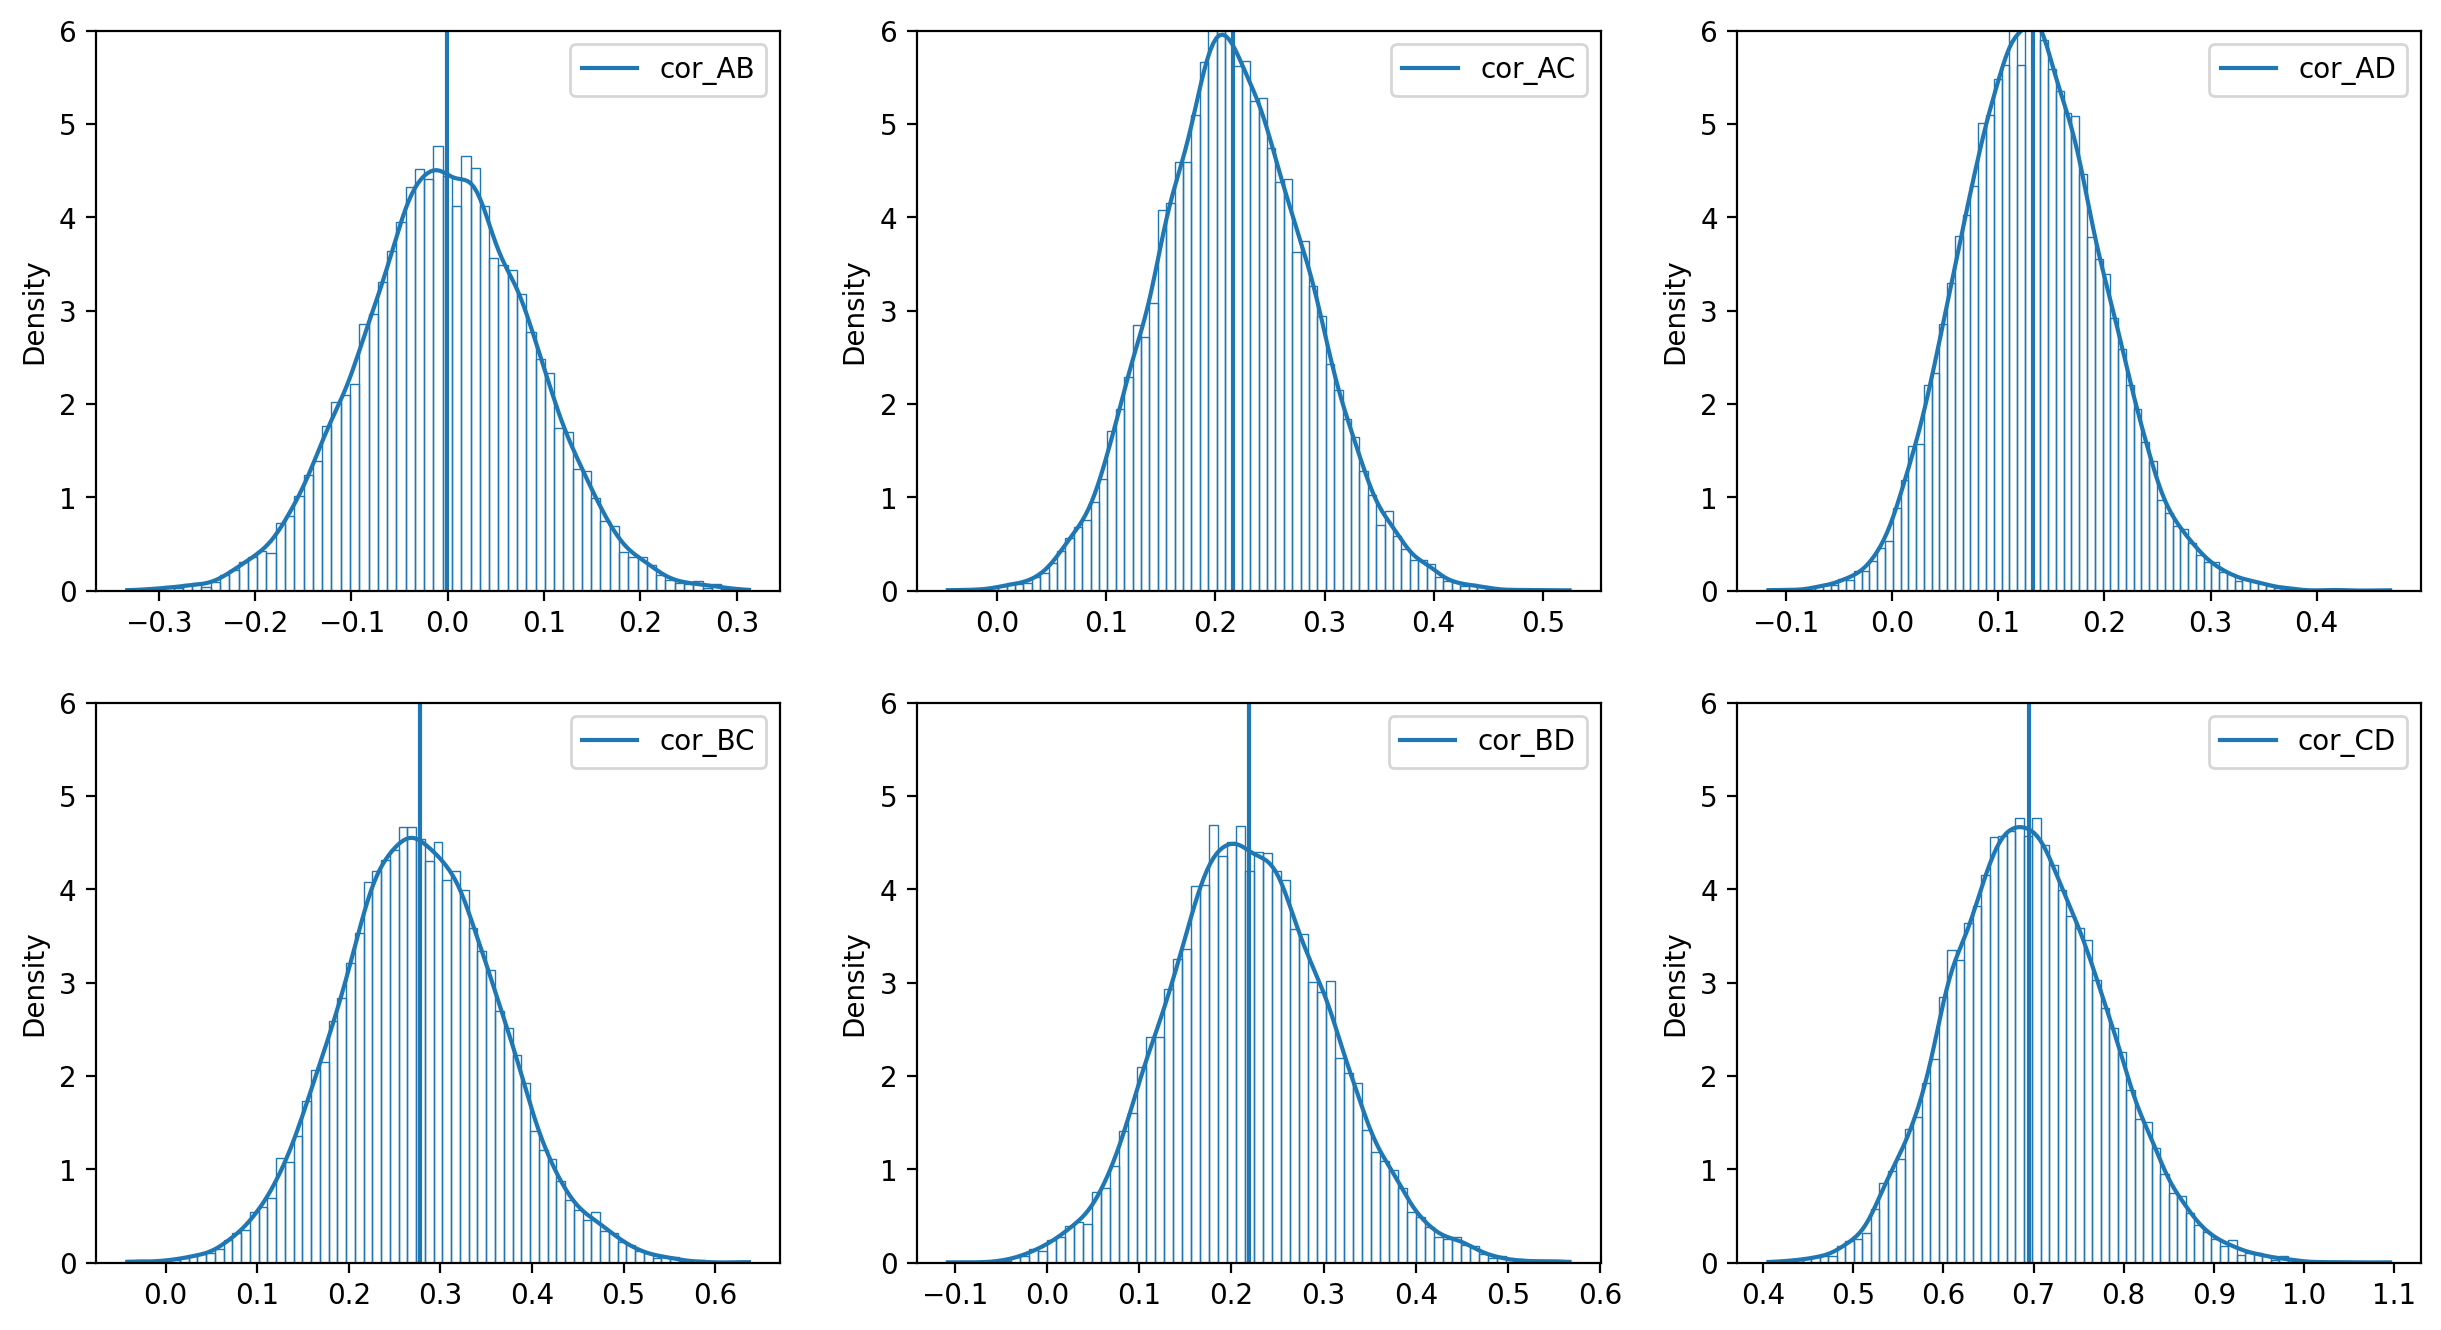

In [88]:
fix, ax = plt.subplots(2,3, figsize = (15,8))

sns.histplot(cor_AB, kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(cor_AC, kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(cor_AD, kde=True, ax=ax[0,2], fill= False, stat = "density");
sns.histplot(cor_BC, kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(cor_BD, kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(cor_CD, kde=True, ax=ax[1,2], fill= False, stat = "density");

ax[0,0].vlines(np.mean(cor_AB), ymin=0, ymax=10)
ax[0,1].vlines(np.mean(cor_AC), ymin=0, ymax=10)
ax[0,2].vlines(np.mean(cor_AD), ymin=0, ymax=10)
ax[1,0].vlines(np.mean(cor_BC), ymin=0, ymax=10)
ax[1,1].vlines(np.mean(cor_BD), ymin=0, ymax=10)
ax[1,2].vlines(np.mean(cor_CD), ymin=0, ymax=10)

for m in [0,1]:
    for n in [0,1,2]:
        ax[m,n].set_ylim((0,6))

ax[0,0].legend(["cor_AB"])
ax[0,1].legend(["cor_AC"])
ax[0,2].legend(["cor_AD"])
ax[1,0].legend(["cor_BC"])
ax[1,1].legend(["cor_BD"])
ax[1,2].legend(["cor_CD"])

In [89]:
given_C_data = data[data['C']==0]
A_given_C = given_C_data['A']
B_given_C = given_C_data['B']
D_given_C = given_C_data['D']
num_step_given_C = math.floor(len(given_C_data)/length)

A_and_B_given_C_dist, A_and_D_given_C_dist, B_and_D_given_C_dist = [np.zeros((1,num_step_given_C)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_C):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_C_dist[i] = np.sum(A_given_C*B_given_C[(i-1)*length:i*length])
    A_and_D_given_C_dist[i] = np.sum(A_given_C*D_given_C[(i-1)*length:i*length])
    B_and_D_given_C_dist[i] = np.sum(A_given_C*D_given_C[(i-1)*length:i*length])

In [90]:
with pm.Model() as model4:
    prior_alpha = 2
    prior_beta = 1

    alpha0_A_and_B_given_C = pm.Gamma('alpha0_A_and_B_given_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D_given_C = pm.Gamma('alpha0_A_and_D_given_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D_given_C = pm.Gamma('alpha0_B_and_D_given_C', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B_given_C = pm.Gamma('beta0_A_and_B_given_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D_given_C = pm.Gamma('beta0_A_and_D_given_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D_given_C = pm.Gamma('beta0_B_and_D_given_C', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_C = pm.Beta('p_A_and_B_given_C', alpha = alpha0_A_and_B_given_C, beta= beta0_A_and_B_given_C)
    p_A_and_D_given_C = pm.Beta('p_A_and_D_given_C', alpha = alpha0_A_and_D_given_C, beta= beta0_A_and_D_given_C)
    p_B_and_D_given_C = pm.Beta('p_B_and_D_given_C', alpha = alpha0_B_and_D_given_C, beta= beta0_B_and_D_given_C)

    bino_A_and_B_given_C = pm.Binomial('bino_A_and_B_given_C', n = length, p= p_A_and_B_given_C, observed = A_and_B_given_C_dist)
    bino_A_and_D_given_C = pm.Binomial('bino_A_and_D_given_C', n = length, p= p_A_and_D_given_C, observed = A_and_D_given_C_dist)
    bino_B_and_D_given_C = pm.Binomial('bino_B_and_D_given_C', n = length, p= p_B_and_D_given_C, observed = B_and_D_given_C_dist)

with model4:
    samples4=pm.sample(draws=4000)

samples_p_A_and_B_given_C = samples4.posterior.p_A_and_B_given_C.values[:,500:].ravel()
samples_p_A_and_D_given_C = samples4.posterior.p_A_and_D_given_C.values[:,500:].ravel()
samples_p_B_and_D_given_C = samples4.posterior.p_B_and_D_given_C.values[:,500:].ravel()

# pm.plot_trace(samples4, 
#             var_names = ['p_A_and_B_given_C', 'p_A_and_D_given_C', 'p_B_and_D_given_C'],
#             filter_vars="like", combined=True, kind="trace", figsize = (12,10));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_and_B_given_C, alpha0_A_and_D_given_C, alpha0_B_and_D_given_C, beta0_A_and_B_given_C, beta0_A_and_D_given_C, beta0_B_and_D_given_C, p_A_and_B_given_C, p_A_and_D_given_C, p_B_and_D_given_C]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 17 seconds.


In [91]:
cor_AB_given_C = phi_corr(samples_p_A_C, samples_p_B_C, samples_p_A_and_B_given_C)
cor_AD_given_C = phi_corr(samples_p_A_C, samples_p_D_C, samples_p_A_and_D_given_C)
cor_BD_given_C = phi_corr(samples_p_B_C, samples_p_D_C, samples_p_B_and_D_given_C)

/var/folders/qm/rsz4z5t17sl3k3c6x1z6j80c0000gn/T/ipykernel_31087/3439649261.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return numerator/denominator


In [92]:
cor_AD_given_C = cor_AD_given_C[cor_AD_given_C<1]
cor_BD_given_C = cor_BD_given_C[cor_BD_given_C<1]

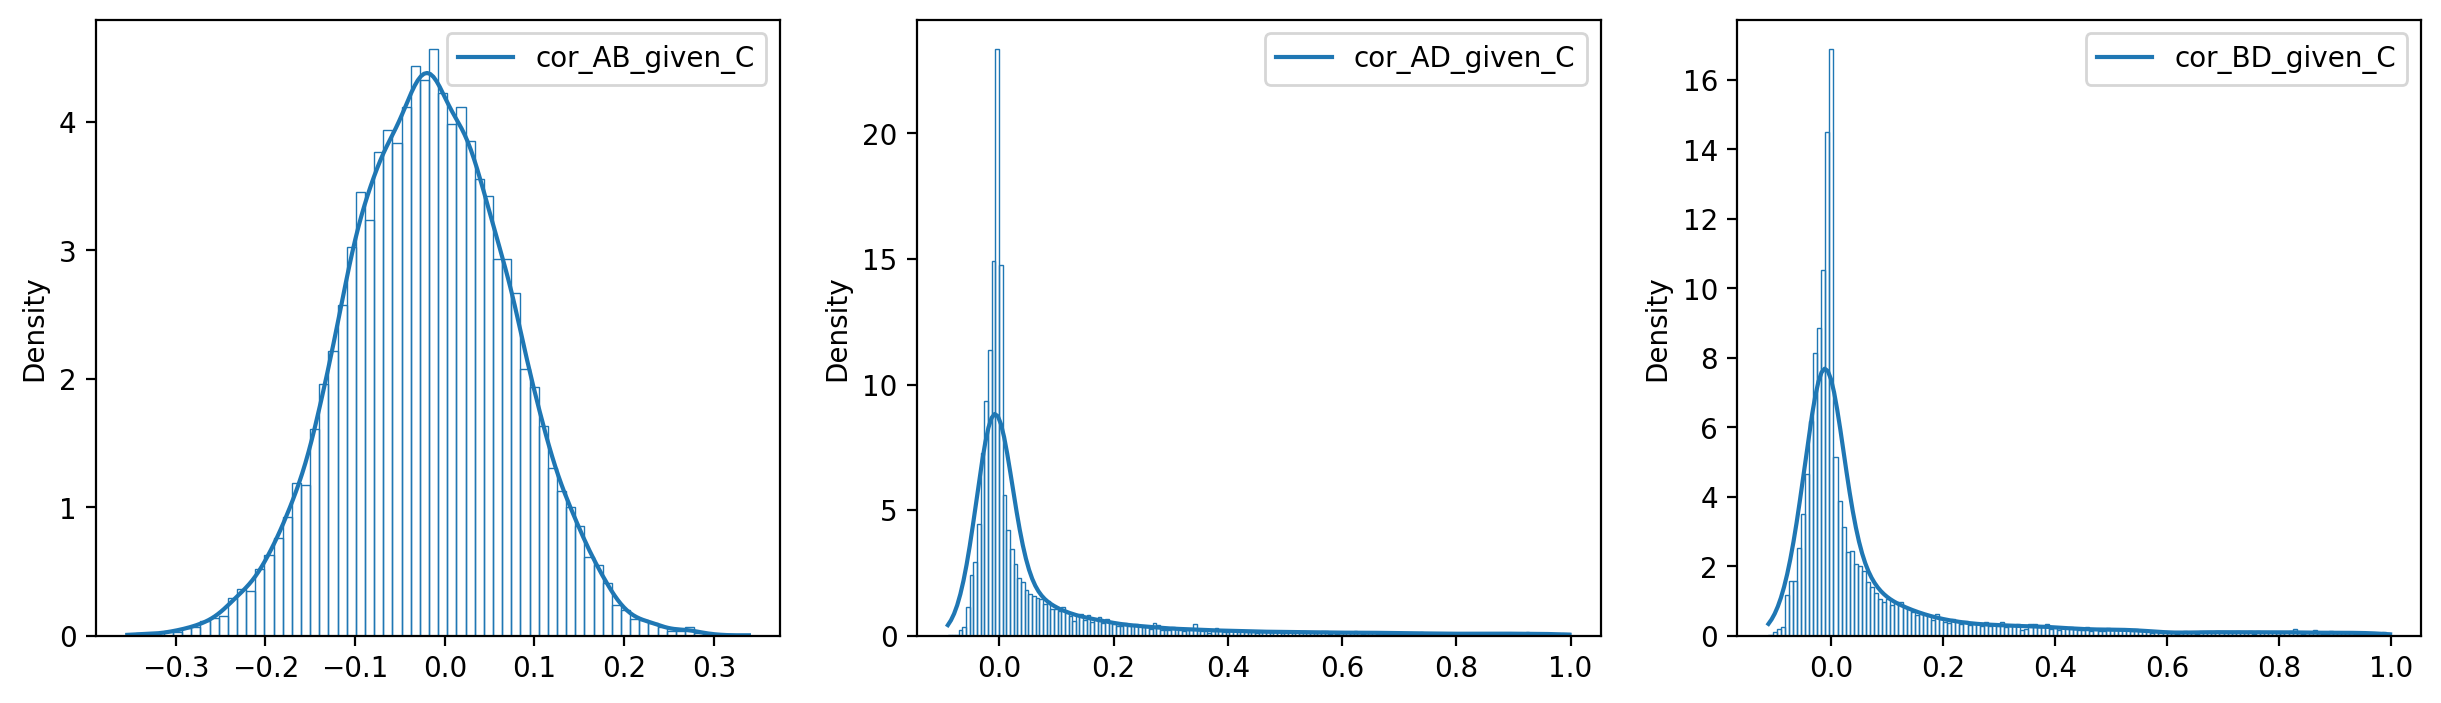

In [93]:
fix, ax = plt.subplots(1,3, figsize = (15,4))

sns.histplot(cor_AB_given_C, kde=True, ax=ax[0], fill= False, stat = "density");
sns.histplot(cor_AD_given_C, kde=True, ax=ax[1], fill= False, stat = "density");
sns.histplot(cor_BD_given_C, kde=True, ax=ax[2], fill= False, stat = "density");

ax[0].legend(["cor_AB_given_C"])
ax[1].legend(["cor_AD_given_C"])
ax[2].legend(["cor_BD_given_C"])

In [94]:
given_D_data = data[data['D']==0]
A_given_D = given_D_data['A']
B_given_D = given_D_data['B']
D_given_D = given_D_data['D']
num_step_given_D = math.floor(len(given_D_data)/length)

A_and_B_given_D_dist, A_and_C_given_D_dist, B_and_C_given_D_dist = [np.zeros((1,num_step_given_D)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_D):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_D_dist[i] = np.sum(A_given_D*B_given_D[(i-1)*length:i*length])
    A_and_C_given_D_dist[i] = np.sum(A_given_D*D_given_D[(i-1)*length:i*length])
    B_and_C_given_D_dist[i] = np.sum(A_given_D*D_given_D[(i-1)*length:i*length])

In [95]:
with pm.Model() as model5:
    prior_alpha = 2
    prior_beta = 1

    alpha0_A_and_B_given_D = pm.Gamma('alpha0_A_and_B_given_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_C_given_D = pm.Gamma('alpha0_A_and_C_given_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_C_given_D = pm.Gamma('alpha0_B_and_C_given_D', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B_given_D = pm.Gamma('beta0_A_and_B_given_D', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_C_given_D = pm.Gamma('beta0_A_and_C_given_D', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_C_given_D = pm.Gamma('beta0_B_and_C_given_D', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_D = pm.Beta('p_A_and_B_given_D', alpha = alpha0_A_and_B_given_D, beta= beta0_A_and_B_given_D)
    p_A_and_C_given_D = pm.Beta('p_A_and_C_given_D', alpha = alpha0_A_and_C_given_D, beta= beta0_A_and_C_given_D)
    p_B_and_C_given_D = pm.Beta('p_B_and_C_given_D', alpha = alpha0_B_and_C_given_D, beta= beta0_B_and_C_given_D)

    bino_A_and_B_given_D = pm.Binomial('bino_A_and_B_given_D', n = length, p= p_A_and_B_given_D, observed = A_and_B_given_D_dist)
    bino_A_and_C_given_D = pm.Binomial('bino_A_and_C_given_D', n = length, p= p_A_and_C_given_D, observed = A_and_C_given_D_dist)
    bino_B_and_C_given_D = pm.Binomial('bino_B_and_C_given_D', n = length, p= p_B_and_C_given_D, observed = B_and_C_given_D_dist)

with model5:
    samples5=pm.sample(draws=4000)

samples_p_A_and_B_given_D = samples5.posterior.p_A_and_B_given_D.values[:,500:].ravel()
samples_p_A_and_C_given_D = samples5.posterior.p_A_and_C_given_D.values[:,500:].ravel()
samples_p_B_and_C_given_D = samples5.posterior.p_B_and_C_given_D.values[:,500:].ravel()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_and_B_given_D, alpha0_A_and_C_given_D, alpha0_B_and_C_given_D, beta0_A_and_B_given_D, beta0_A_and_C_given_D, beta0_B_and_C_given_D, p_A_and_B_given_D, p_A_and_C_given_D, p_B_and_C_given_D]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 18 seconds.


In [96]:
given_B_and_C_data = data[(data['B'] ==1) & (data['C']==1)]
A_given_B_and_C = given_B_and_C_data['A']
num_step_given_B_and_C = math.floor(len(given_B_and_C_data)/length)

A_given_B_and_C_dist = np.zeros((1,num_step_given_B_and_C)).ravel()

for i in np.arange(num_step_given_B_and_C):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_given_B_and_C_dist[i] = np.sum(A_given_B_and_C[(i-1)*length:i*length])

In [97]:
with pm.Model() as model6:
    prior_alpha = 2
    prior_beta = 1
    
    alpha0_A_given_B_and_C_dist = pm.Gamma('alpha0_A_given_B_and_C_dist', alpha = prior_alpha, beta=prior_beta)
  
    beta0_A_given_B_and_C_dist = pm.Gamma('beta0_A_given_B_and_C_dist', alpha = prior_alpha, beta=prior_beta)
    
    p_A_given_B_and_C_dist = pm.Beta('p_A_given_B_and_C_dist', alpha = alpha0_A_given_B_and_C_dist, beta= beta0_A_given_B_and_C_dist)
    
    bino_A_given_B_and_C_dist = pm.Binomial('bino_A_given_B_and_C_dist', n = length, p= p_A_given_B_and_C_dist, observed = A_given_B_and_C_dist)

with model6:
    samples6=pm.sample(draws=4000)

samples_p_A_given_B_and_C = samples6.posterior.p_A_given_B_and_C_dist.values[:,500:].ravel()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_given_B_and_C_dist, beta0_A_given_B_and_C_dist, p_A_given_B_and_C_dist]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2 seconds.


<AxesSubplot:ylabel='Count'>

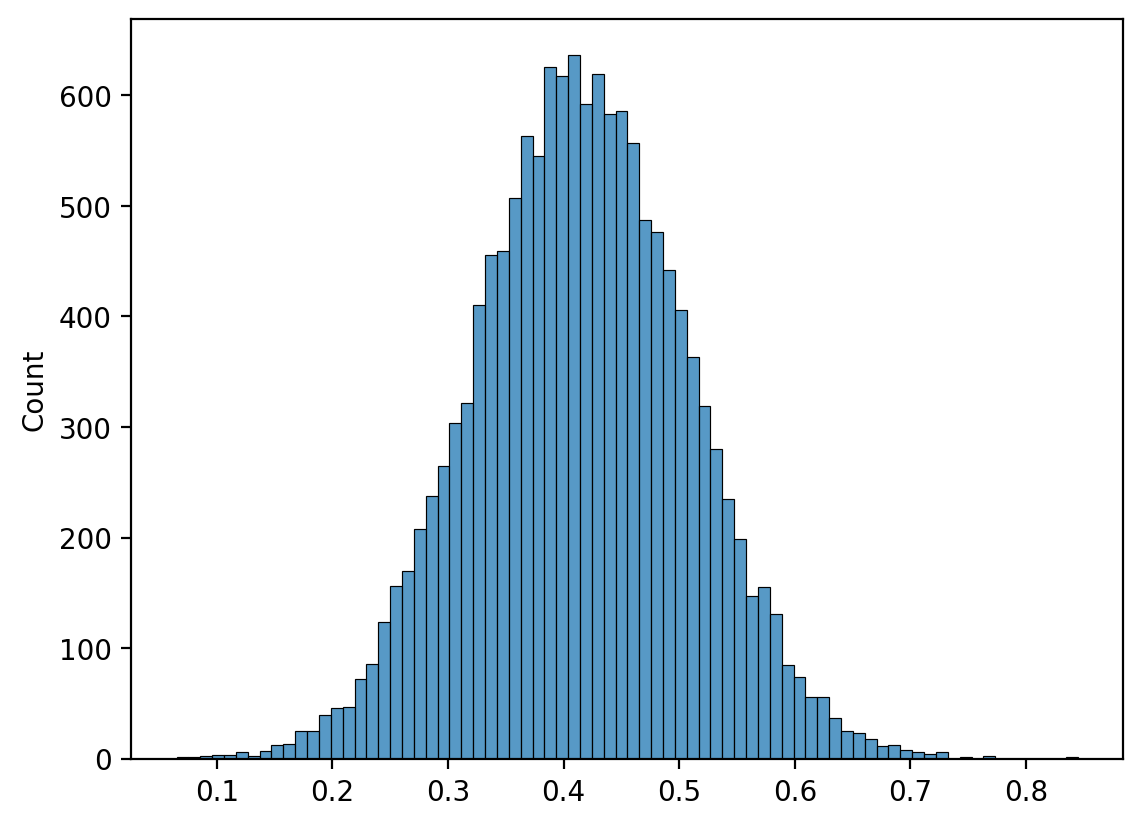

In [122]:
test = phi_corr2(samples_p_A_C,samples_p_B_C,samples_p_A_given_B_and_C)
#test = phi_corr(samples_p_A_C,samples_p_B_C,samples_p_A_and_B_given_C)
sns.histplot(test)

In [99]:
given_C_and_D_data = data[(data['C'] ==0) & (data['D']==0)]
B_given_C_and_D = given_C_and_D_data['B']
num_step_given_C_and_D = math.floor(len(given_C_and_D_data)/length)

B_given_C_and_D_dist = np.zeros((1,num_step_given_C_and_D)).ravel()

for i in np.arange(num_step_given_C_and_D):
    # print(np.sum(A[(i-1)*length:i*length]))
    B_given_C_and_D_dist[i] = np.sum(B_given_C_and_D[(i-1)*length:i*length])

with pm.Model() as model7:
    prior_alpha = 2
    prior_beta = 1
    
    alpha0_B_given_C_and_D_dist = pm.Gamma('alpha0_B_given_C_and_D_dist', alpha = prior_alpha, beta=prior_beta)
    
    beta0_B_given_C_and_D_dist = pm.Gamma('beta0_B_given_C_and_D_dist', alpha = prior_alpha, beta=prior_beta)
    
    p_B_given_C_and_D_dist = pm.Beta('p_B_given_C_and_D_dist', alpha = alpha0_B_given_C_and_D_dist, beta= beta0_B_given_C_and_D_dist)
    
    bino_B_given_C_and_D_dist = pm.Binomial('bino_B_given_C_and_D_dist', n = length, p= p_B_given_C_and_D_dist, observed = B_given_C_and_D_dist)

with model7:
    samples7=pm.sample(draws=4000)

samples_p_B_given_C_and_D = samples7.posterior.p_B_given_C_and_D_dist.values[:,500:].ravel()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_B_given_C_and_D_dist, beta0_B_given_C_and_D_dist, p_B_given_C_and_D_dist]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2 seconds.


/var/folders/qm/rsz4z5t17sl3k3c6x1z6j80c0000gn/T/ipykernel_31087/3439649261.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return numerator/denominator


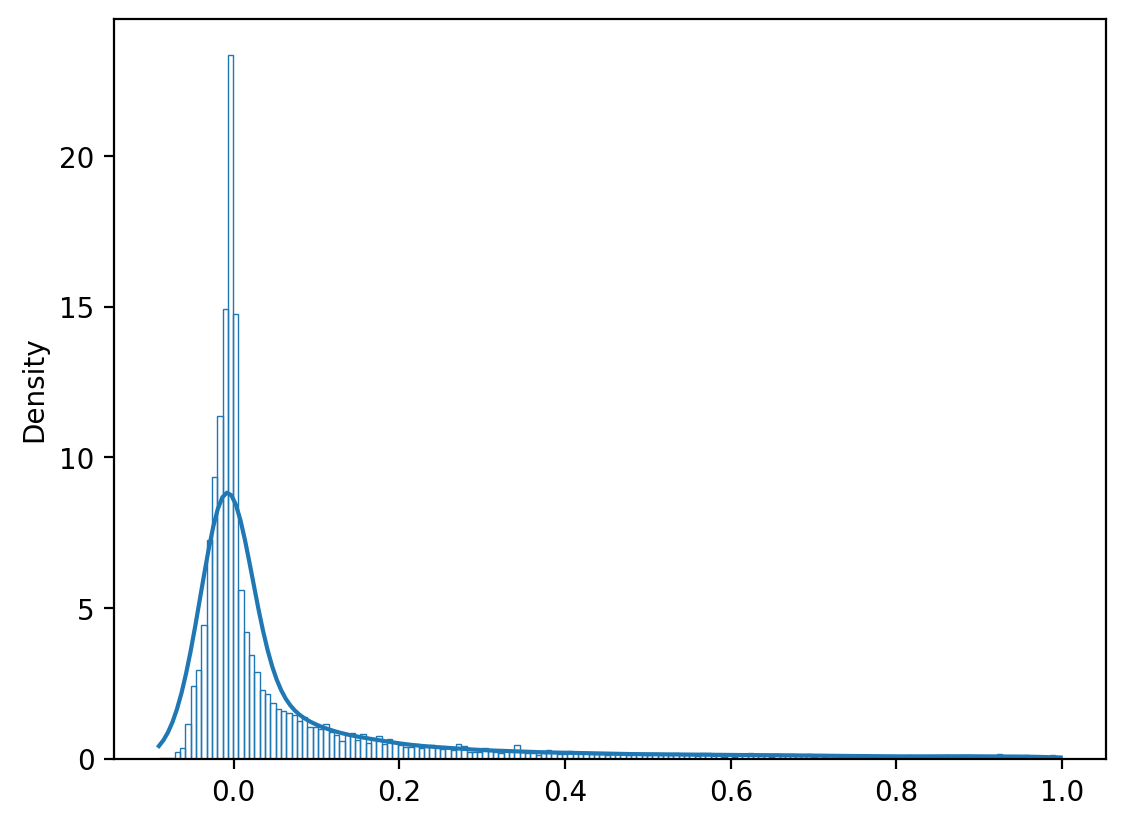

In [100]:
# Check P(A.D|C)

corr_A_and_D_given_C0 = phi_corr(samples_p_A_C,samples_p_D_C,samples_p_A_and_D_given_C);
corr_A_and_D_given_C0 = corr_A_and_D_given_C0[corr_A_and_D_given_C0<1];
sns.histplot(corr_A_and_D_given_C0, kde=True, fill= False, stat = "density");

# if we condition C = 0; there is no direct path A -> D and D -> A

/var/folders/qm/rsz4z5t17sl3k3c6x1z6j80c0000gn/T/ipykernel_31087/3439649261.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return numerator/denominator


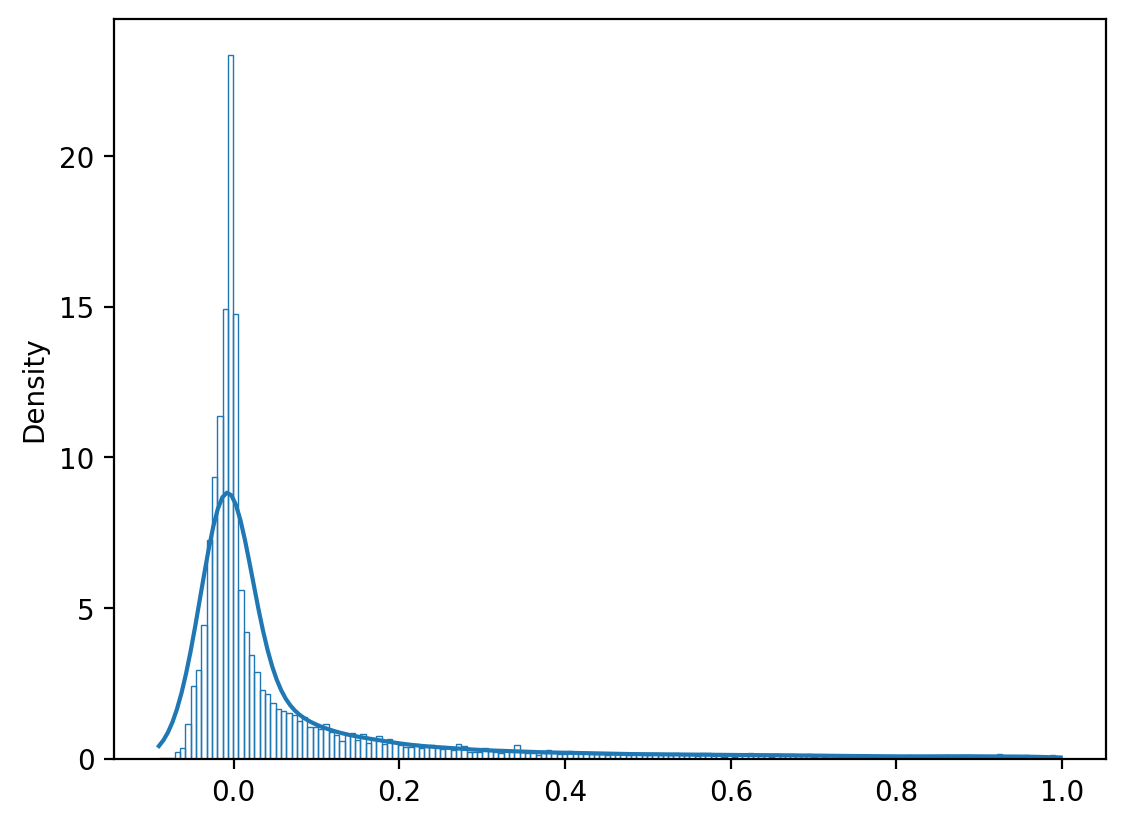

In [101]:
# Check P(B,D|C)

corr_B_and_D_given_C0 = phi_corr(samples_p_B_C,samples_p_D_C,samples_p_B_and_D_given_C);
corr_B_and_D_given_C0 = corr_B_and_D_given_C0[corr_B_and_D_given_C0<1];
sns.histplot(corr_A_and_D_given_C0, kde=True, fill= False, stat = "density");

# if we condition C = 0; there is no direct path B -> D or D -> B

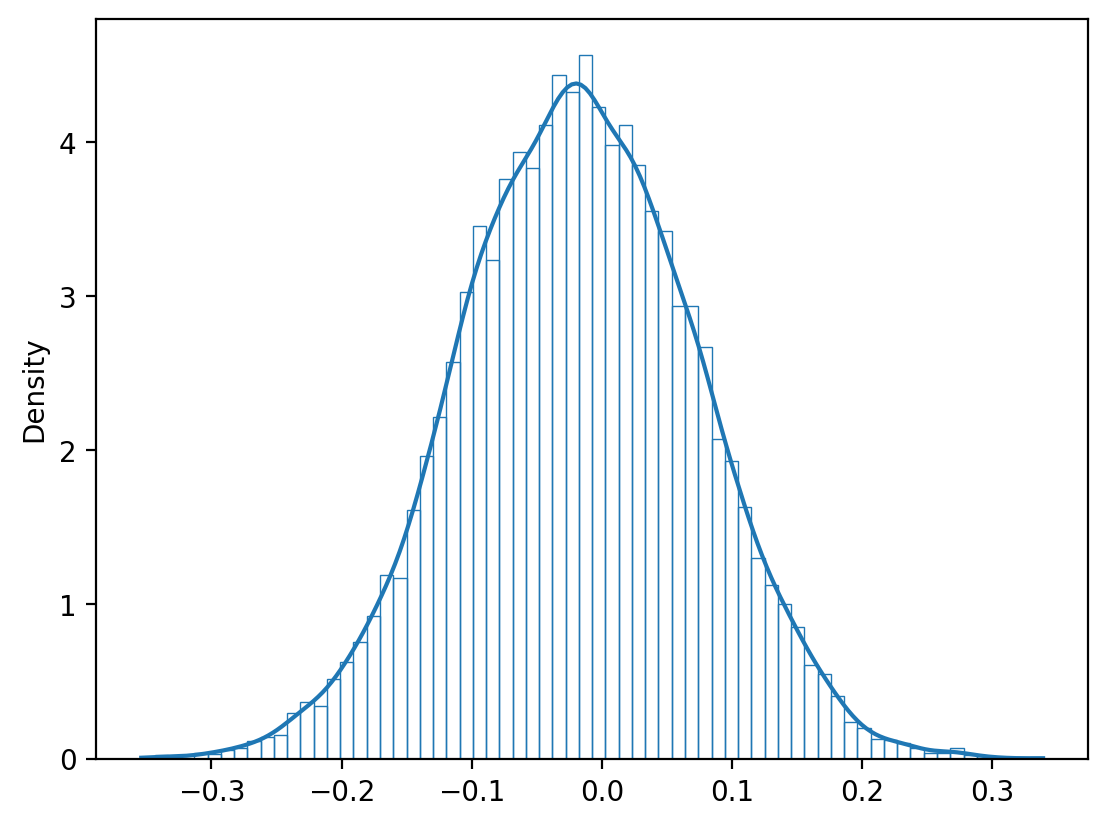

In [102]:
# Check P(A.B|C)

corr_A_and_B_given_C0 = phi_corr(samples_p_A_C,samples_p_B_C,samples_p_A_and_B_given_C);
corr_A_and_B_given_C0 = corr_A_and_B_given_C0[corr_A_and_B_given_C0<1];
sns.histplot(corr_A_and_B_given_C0, kde=True, fill= False, stat = "density");

# if we condition C = 0; there is no direct path A -> D and D -> A

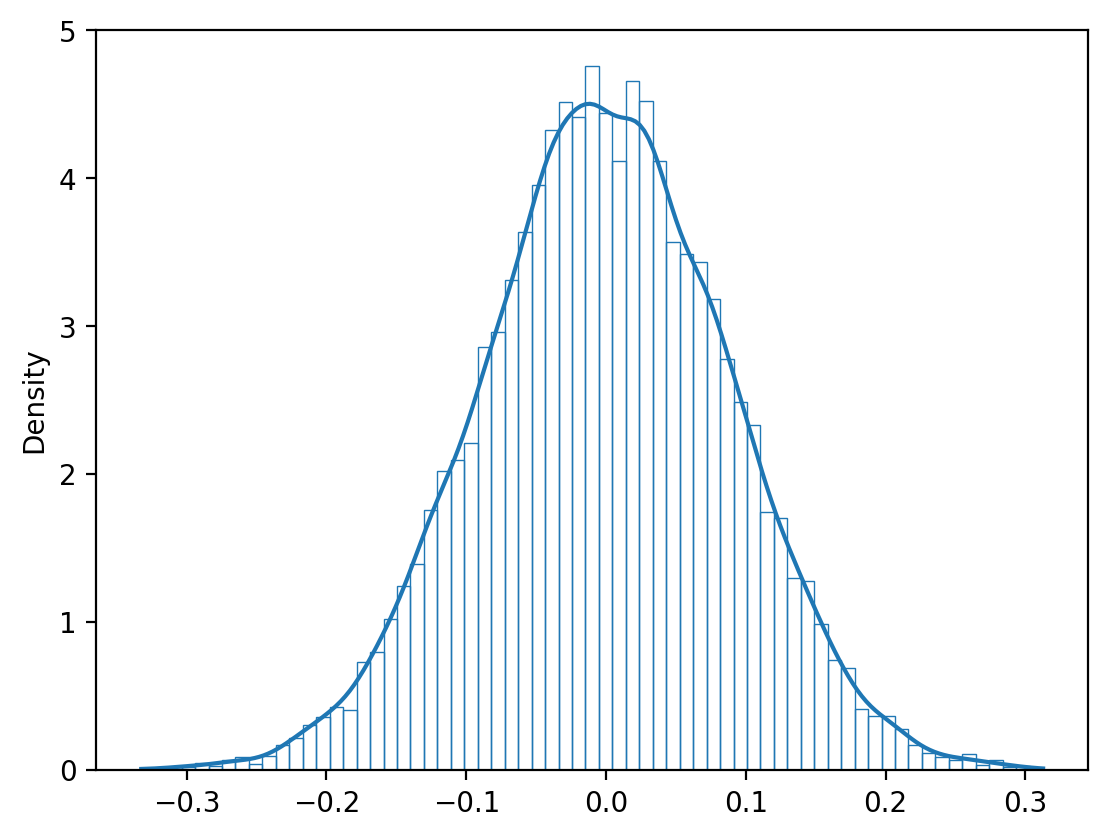

In [103]:
# Check P(A.B|C)

corr_A_and_B = phi_corr(samples_p_A,samples_p_B,samples_p_A_and_B);
corr_A_and_B = corr_A_and_B[corr_A_and_B<1];
sns.histplot(corr_A_and_B, kde=True, fill= False, stat = "density");

# if we condition C = 0; there is no direct path A -> D and D -> A

In [114]:
B_A_data = data[data['A']==0]['B']
C_A_data = data[data['A']==0]['C']
D_A_data = data[data['A']==0]['D']
print(len(B_A_data))

A_B_data = data[data['B']==0]['A']
C_B_data = data[data['B']==0]['C']
D_B_data = data[data['B']==0]['D']
print(len(A_B_data))

A_C_data = data[data['C']==0]['A']
B_C_data = data[data['C']==0]['B']
D_C_data = data[data['C']==0]['D']
print(len(A_C_data))

A_D_data = data[data['D']==0]['A']
B_D_data = data[data['D']==0]['B']
C_D_data = data[data['D']==0]['C']
print(len(C_D_data))

487
295
705
833


In [115]:
num_step_given_A = math.floor(len(B_A_data)/length)
num_step_given_B = math.floor(len(A_B_data)/length)
num_step_given_C = math.floor(len(A_C_data)/length)
num_step_given_D = math.floor(len(A_D_data)/length)

B_A_dist, C_A_dist, D_A_dist = [np.zeros((1,num_step_given_A)).ravel() for i in [1,1,1]]
A_B_dist, C_B_dist, D_B_dist = [np.zeros((1,num_step_given_B)).ravel() for i in [1,1,1]]
A_C_dist, B_C_dist, D_C_dist = [np.zeros((1,num_step_given_C)).ravel() for i in [1,1,1]]
A_D_dist, B_D_dist, C_D_dist = [np.zeros((1,num_step_given_D)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_A):
    B_A_dist[i] = np.sum(B_A_data[(i-1)*length:i*length])
    C_A_dist[i] = np.sum(C_A_data[(i-1)*length:i*length])
    D_A_dist[i] = np.sum(D_A_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_B):
    A_B_dist[i] = np.sum(A_B_data[(i-1)*length:i*length])
    C_B_dist[i] = np.sum(C_B_data[(i-1)*length:i*length])
    D_B_dist[i] = np.sum(D_B_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_C):
    A_C_dist[i] = np.sum(A_C_data[(i-1)*length:i*length])
    B_C_dist[i] = np.sum(B_C_data[(i-1)*length:i*length])
    D_C_dist[i] = np.sum(D_C_data[(i-1)*length:i*length])

for i in np.arange(num_step_given_D):
    A_D_dist[i] = np.sum(A_D_data[(i-1)*length:i*length])
    B_D_dist[i] = np.sum(B_D_data[(i-1)*length:i*length])
    C_D_dist[i] = np.sum(C_D_data[(i-1)*length:i*length])

with pm.Model() as model2:
    prior_alpha = 2
    prior_beta = 1

    # Let's start conditional dist. 
    alpha0_A_B = pm.Gamma('alpha0_A_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_C = pm.Gamma('alpha0_A_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_D = pm.Gamma('alpha0_A_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_A = pm.Gamma('alpha0_B_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_C = pm.Gamma('alpha0_B_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_D = pm.Gamma('alpha0_B_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_A = pm.Gamma('alpha0_C_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_B = pm.Gamma('alpha0_C_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_D = pm.Gamma('alpha0_C_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_A = pm.Gamma('alpha0_D_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_B = pm.Gamma('alpha0_D_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_C = pm.Gamma('alpha0_D_C', alpha = prior_alpha, beta=prior_beta)

    beta0_A_B = pm.Gamma('beta0_A_B', alpha = prior_alpha, beta=prior_beta)
    beta0_A_C = pm.Gamma('beta0_A_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_D = pm.Gamma('beta0_A_D', alpha = prior_alpha, beta=prior_beta)
    beta0_B_A = pm.Gamma('beta0_B_A', alpha = prior_alpha, beta=prior_beta)
    beta0_B_C = pm.Gamma('beta0_B_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_D = pm.Gamma('beta0_B_D', alpha = prior_alpha, beta=prior_beta)
    beta0_C_A = pm.Gamma('beta0_C_A', alpha = prior_alpha, beta=prior_beta)
    beta0_C_B = pm.Gamma('beta0_C_B', alpha = prior_alpha, beta=prior_beta)
    beta0_C_D = pm.Gamma('beta0_C_D', alpha = prior_alpha, beta=prior_beta)
    beta0_D_A = pm.Gamma('beta0_D_A', alpha = prior_alpha, beta=prior_beta)
    beta0_D_B = pm.Gamma('beta0_D_B', alpha = prior_alpha, beta=prior_beta)
    beta0_D_C = pm.Gamma('beta0_D_C', alpha = prior_alpha, beta=prior_beta)

    p_A_B = pm.Beta('p_A_B', alpha = alpha0_A_B, beta= beta0_A_B)
    p_A_C = pm.Beta('p_A_C', alpha = alpha0_A_C, beta= beta0_A_C)
    p_A_D = pm.Beta('p_A_D', alpha = alpha0_A_D, beta= beta0_A_D)
    p_B_A = pm.Beta('p_B_A', alpha = alpha0_B_A, beta= beta0_B_A)
    p_B_C = pm.Beta('p_B_C', alpha = alpha0_B_C, beta= beta0_B_C)
    p_B_D = pm.Beta('p_B_D', alpha = alpha0_B_D, beta= beta0_B_D)
    p_C_A = pm.Beta('p_C_A', alpha = alpha0_C_A, beta= beta0_C_A)
    p_C_B = pm.Beta('p_C_B', alpha = alpha0_C_B, beta= beta0_C_B)
    p_C_D = pm.Beta('p_C_D', alpha = alpha0_C_D, beta= beta0_C_D)
    p_D_A = pm.Beta('p_D_A', alpha = alpha0_D_A, beta= beta0_D_A)
    p_D_B = pm.Beta('p_D_B', alpha = alpha0_D_B, beta= beta0_D_B)
    p_D_C = pm.Beta('p_D_C', alpha = alpha0_D_C, beta= beta0_D_C)

    # They are for to get conditional probabilities
    bino_A_B = pm.Binomial('bino_A_B', n = length, p= p_A_B, observed = A_B_dist)
    bino_A_C = pm.Binomial('bino_A_C', n = length, p= p_A_C, observed = A_C_dist)
    bino_A_D = pm.Binomial('bino_A_D', n = length, p= p_A_D, observed = A_D_dist)
    bino_B_A = pm.Binomial('bino_B_A', n = length, p= p_B_A, observed = B_A_dist)
    bino_B_C = pm.Binomial('bino_B_C', n = length, p= p_B_C, observed = B_C_dist)
    bino_B_D = pm.Binomial('bino_B_D', n = length, p= p_B_D, observed = B_D_dist)
    bino_C_A = pm.Binomial('bino_C_A', n = length, p= p_C_A, observed = C_A_dist)
    bino_C_B = pm.Binomial('bino_C_B', n = length, p= p_C_B, observed = C_B_dist)
    bino_C_D = pm.Binomial('bino_C_D', n = length, p= p_C_D, observed = C_D_dist)
    bino_D_A = pm.Binomial('bino_D_A', n = length, p= p_D_A, observed = D_A_dist)
    bino_D_B = pm.Binomial('bino_D_B', n = length, p= p_D_B, observed = D_B_dist)
    bino_D_C = pm.Binomial('bino_D_C', n = length, p= p_D_C, observed = D_C_dist)

with model2:
    samples2 = pm.sample(draws = 4000)

# pm.plot_trace(samples2, 
#             var_names = ['p_A_B', 'p_A_C', 'p_A_D', 'p_B_A', 'p_B_C', 'p_B_D', 
#             'p_C_A', 'p_C_B', 'p_C_D', 'p_D_A', 'p_D_B', 'p_D_C'],
#             filter_vars="like", combined=True, kind="trace", figsize = (12,40));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_B, alpha0_A_C, alpha0_A_D, alpha0_B_A, alpha0_B_C, alpha0_B_D, alpha0_C_A, alpha0_C_B, alpha0_C_D, alpha0_D_A, alpha0_D_B, alpha0_D_C, beta0_A_B, beta0_A_C, beta0_A_D, beta0_B_A, beta0_B_C, beta0_B_D, beta0_C_A, beta0_C_B, beta0_C_D, beta0_D_A, beta0_D_B, beta0_D_C, p_A_B, p_A_C, p_A_D, p_B_A, p_B_C, p_B_D, p_C_A, p_C_B, p_C_D, p_D_A, p_D_B, p_D_C]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 76 seconds.


In [116]:
samples_p_A_B = samples2.posterior.p_A_B.values[:,500:].ravel()
samples_p_A_C = samples2.posterior.p_A_C.values[:,500:].ravel()
samples_p_A_D = samples2.posterior.p_A_D.values[:,500:].ravel()
samples_p_B_A = samples2.posterior.p_B_A.values[:,500:].ravel()
samples_p_B_C = samples2.posterior.p_B_C.values[:,500:].ravel()
samples_p_B_D = samples2.posterior.p_B_D.values[:,500:].ravel()
samples_p_C_A = samples2.posterior.p_C_A.values[:,500:].ravel()
samples_p_C_B = samples2.posterior.p_C_B.values[:,500:].ravel()
samples_p_C_D = samples2.posterior.p_C_D.values[:,500:].ravel()
samples_p_D_A = samples2.posterior.p_D_A.values[:,500:].ravel()
samples_p_D_B = samples2.posterior.p_D_B.values[:,500:].ravel()
samples_p_D_C = samples2.posterior.p_D_C.values[:,500:].ravel()

In [117]:
given_C_data = data[data['C']==0]
A_given_C = given_C_data['A']
B_given_C = given_C_data['B']
D_given_C = given_C_data['D']
num_step_given_C = math.floor(len(given_C_data)/length)

A_and_B_given_C_dist, A_and_D_given_C_dist, B_and_D_given_C_dist = [np.zeros((1,num_step_given_C)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_C):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_C_dist[i] = np.sum(A_given_C*B_given_C[(i-1)*length:i*length])
    A_and_D_given_C_dist[i] = np.sum(A_given_C*D_given_C[(i-1)*length:i*length])
    B_and_D_given_C_dist[i] = np.sum(A_given_C*D_given_C[(i-1)*length:i*length])

with pm.Model() as model4:
    prior_alpha = 2
    prior_beta = 1

    alpha0_A_and_B_given_C = pm.Gamma('alpha0_A_and_B_given_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D_given_C = pm.Gamma('alpha0_A_and_D_given_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D_given_C = pm.Gamma('alpha0_B_and_D_given_C', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B_given_C = pm.Gamma('beta0_A_and_B_given_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D_given_C = pm.Gamma('beta0_A_and_D_given_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D_given_C = pm.Gamma('beta0_B_and_D_given_C', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_C = pm.Beta('p_A_and_B_given_C', alpha = alpha0_A_and_B_given_C, beta= beta0_A_and_B_given_C)
    p_A_and_D_given_C = pm.Beta('p_A_and_D_given_C', alpha = alpha0_A_and_D_given_C, beta= beta0_A_and_D_given_C)
    p_B_and_D_given_C = pm.Beta('p_B_and_D_given_C', alpha = alpha0_B_and_D_given_C, beta= beta0_B_and_D_given_C)

    bino_A_and_B_given_C = pm.Binomial('bino_A_and_B_given_C', n = length, p= p_A_and_B_given_C, observed = A_and_B_given_C_dist)
    bino_A_and_D_given_C = pm.Binomial('bino_A_and_D_given_C', n = length, p= p_A_and_D_given_C, observed = A_and_D_given_C_dist)
    bino_B_and_D_given_C = pm.Binomial('bino_B_and_D_given_C', n = length, p= p_B_and_D_given_C, observed = B_and_D_given_C_dist)

with model4:
    samples4=pm.sample(draws=4000)

samples_p_A_and_B_given_C = samples4.posterior.p_A_and_B_given_C.values[:,500:].ravel()
samples_p_A_and_D_given_C = samples4.posterior.p_A_and_D_given_C.values[:,500:].ravel()
samples_p_B_and_D_given_C = samples4.posterior.p_B_and_D_given_C.values[:,500:].ravel()

# pm.plot_trace(samples4, 
#             var_names = ['p_A_and_B_given_C', 'p_A_and_D_given_C', 'p_B_and_D_given_C'],
#             filter_vars="like", combined=True, kind="trace", figsize = (12,10));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A_and_B_given_C, alpha0_A_and_D_given_C, alpha0_B_and_D_given_C, beta0_A_and_B_given_C, beta0_A_and_D_given_C, beta0_B_and_D_given_C, p_A_and_B_given_C, p_A_and_D_given_C, p_B_and_D_given_C]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 19 seconds.


<AxesSubplot:ylabel='Density'>

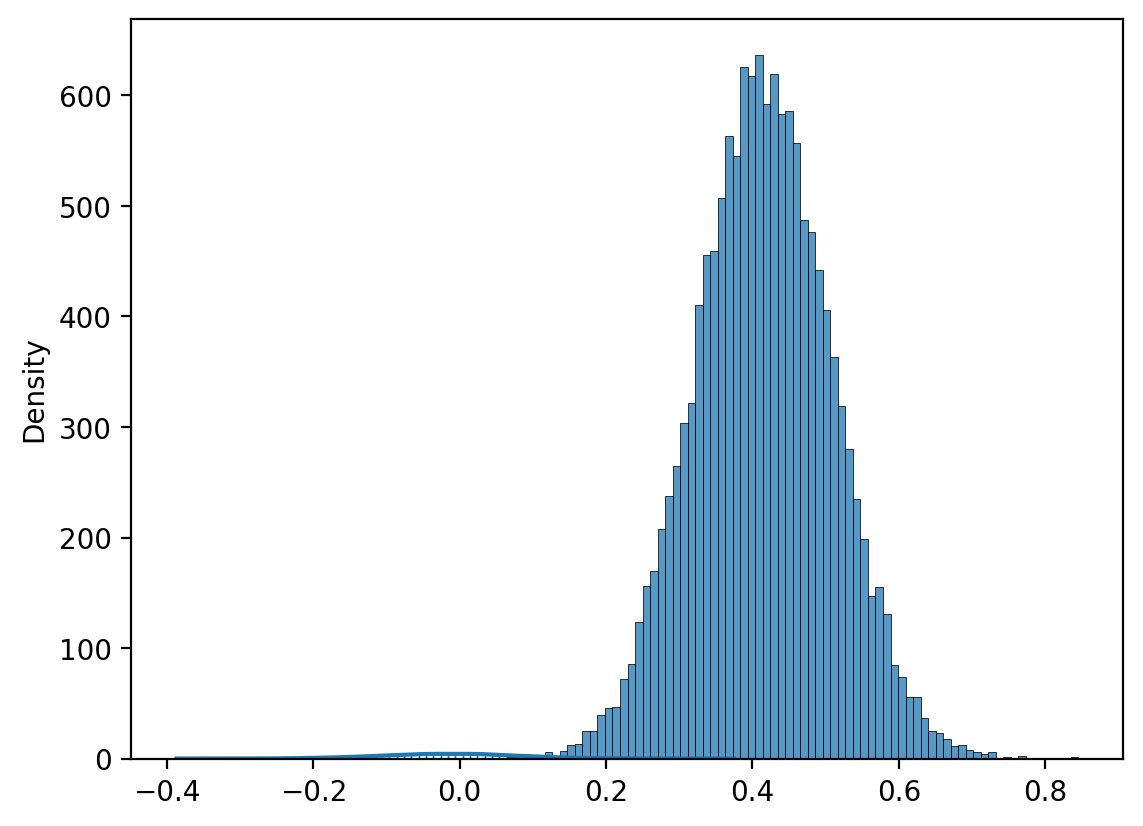

In [120]:
# Check P(A.B|C=1)

corr_A_and_B_given_C1 = phi_corr(samples_p_A_C,samples_p_B_C,samples_p_A_and_B_given_C);
corr_A_and_B_given_C1 = corr_A_and_B_given_C1[corr_A_and_B_given_C1<1];
sns.histplot(corr_A_and_B_given_C1, kde=True, fill= False, stat = "density");

test = phi_corr2(samples_p_A_C,samples_p_B_C,samples_p_A_given_B_and_C)
sns.histplot(test)

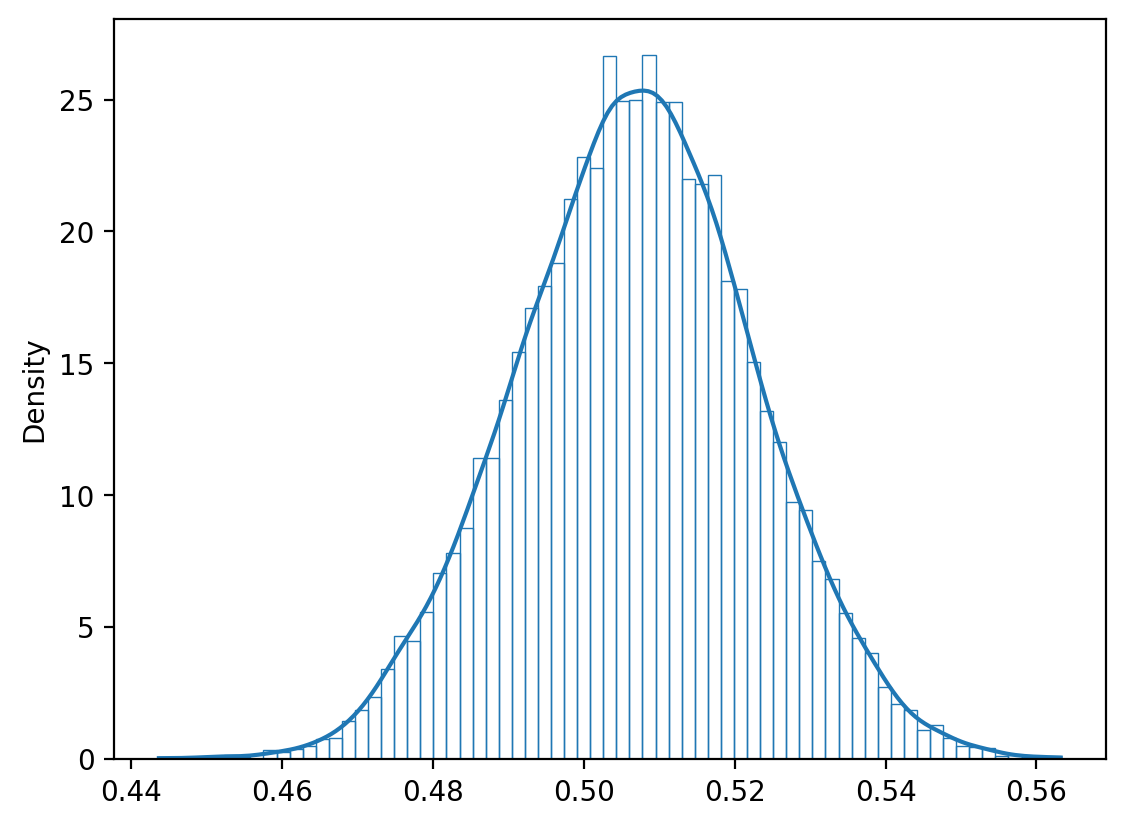

In [125]:
sns.histplot(samples_p_A,kde=True, fill= False, stat = "density");

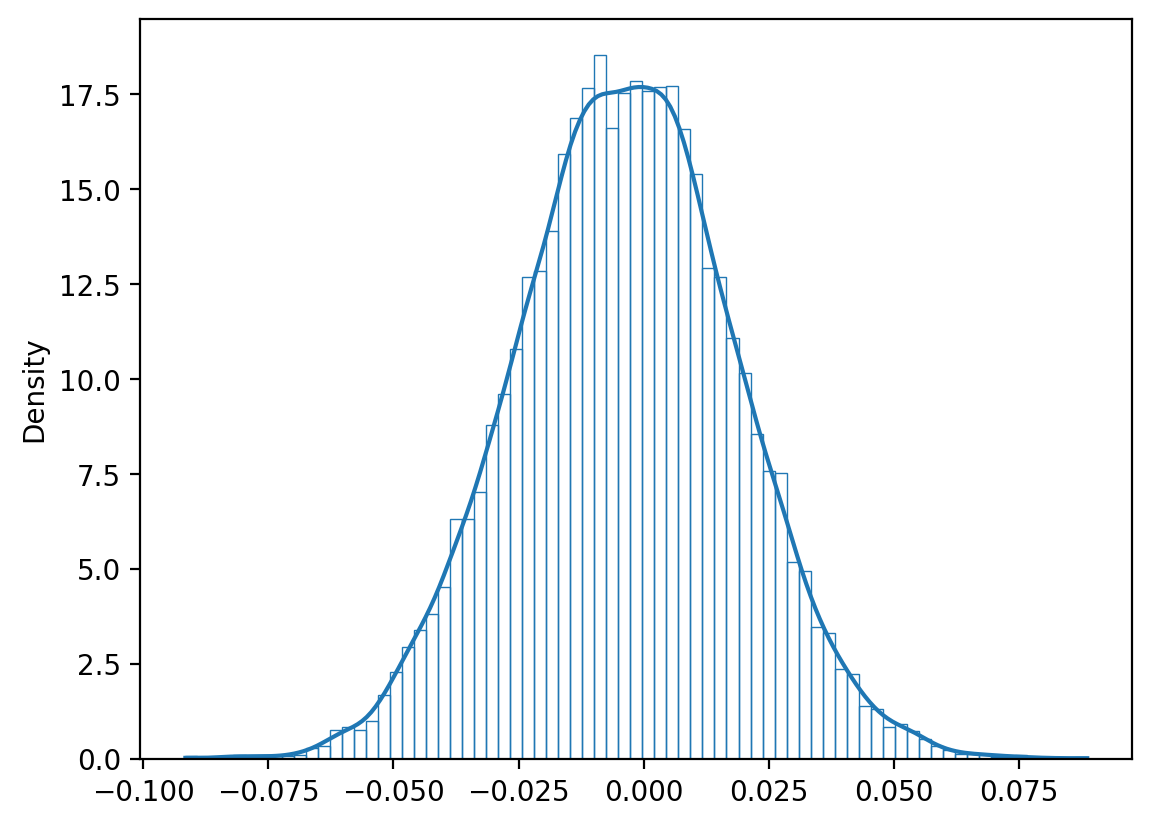

In [123]:
# Check P(A.B|C=1)
test = samples_p_A_and_B_given_C-samples_p_A_C*samples_p_B_C
sns.histplot(test, kde=True, fill= False, stat = "density");

<AxesSubplot:ylabel='Count'>

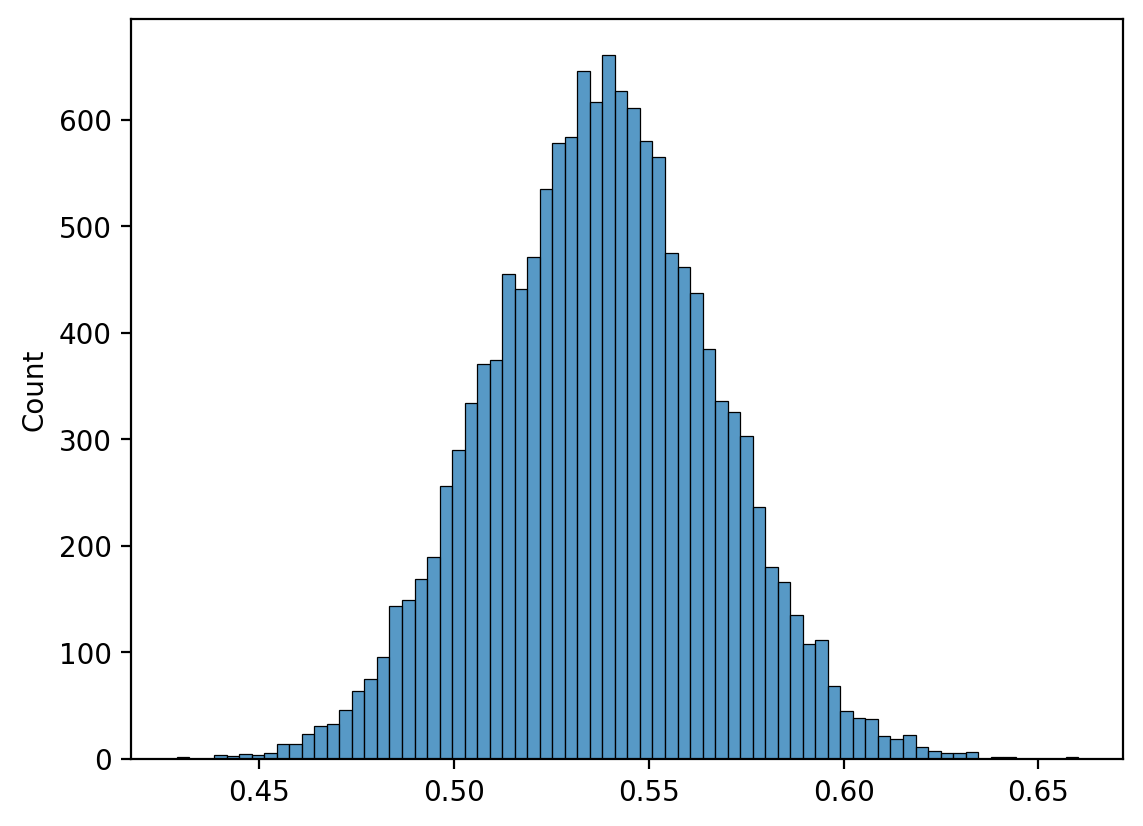

In [110]:
sns.histplot(samples_p_A_and_B_given_C)

<AxesSubplot:ylabel='Count'>

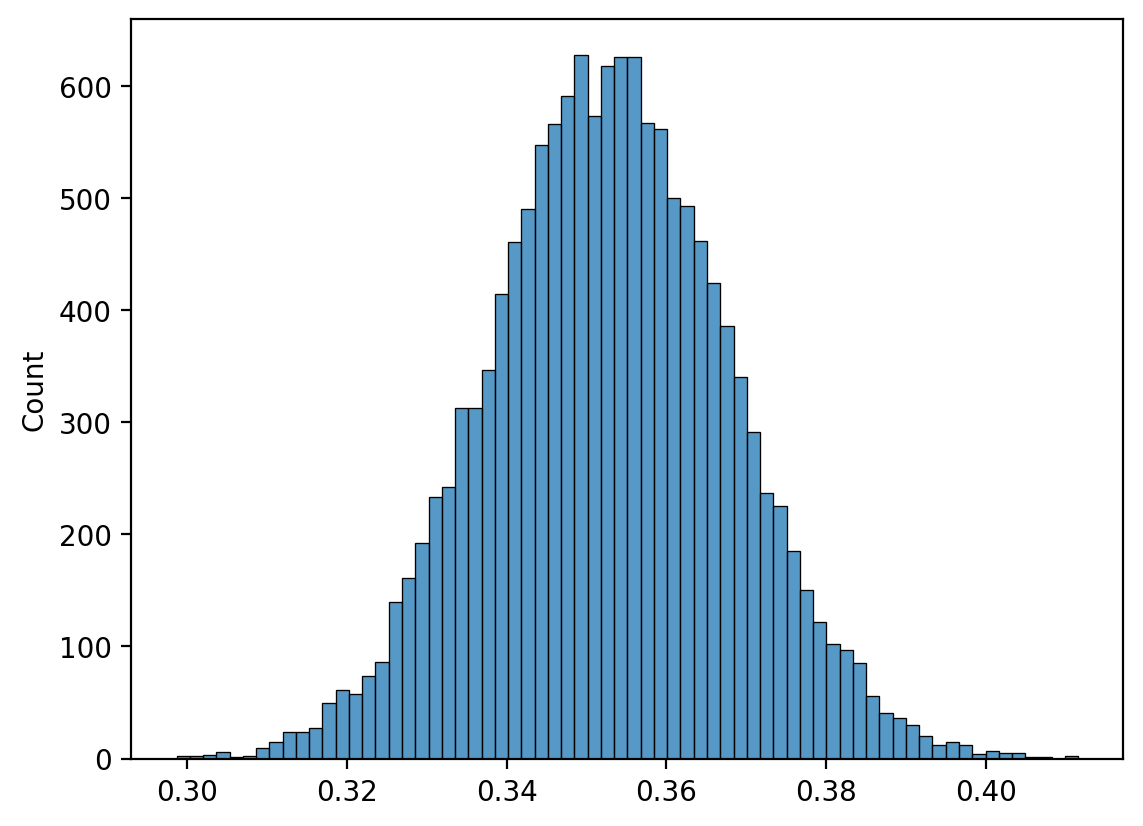

In [111]:
sns.histplot(samples_p_A_and_B)